# Assignment 4
**Recurrent Neural Network (RNN)**: Use the Google stock prices dataset and design a time series analysis and prediction system using RNN.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
# load the dataset
df = pd.read_csv('google_stock_price_train.csv', thousands=',')

In [3]:
# view
df

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,7380500
1,1/4/2012,331.27,333.87,329.08,666.45,5749400
2,1/5/2012,329.83,330.75,326.89,657.21,6590300
3,1/6/2012,328.34,328.77,323.68,648.24,5405900
4,1/9/2012,322.04,322.29,309.46,620.76,11688800
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,623400
1254,12/27/2016,790.68,797.86,787.66,791.55,789100
1255,12/28/2016,793.70,794.23,783.20,785.05,1153800
1256,12/29/2016,783.33,785.93,778.92,782.79,744300


### Preprocessing

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   float64
 5   Volume  1258 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 59.1+ KB


In [5]:
# convert to datetime
df['Date'] = pd.to_datetime(df['Date'])

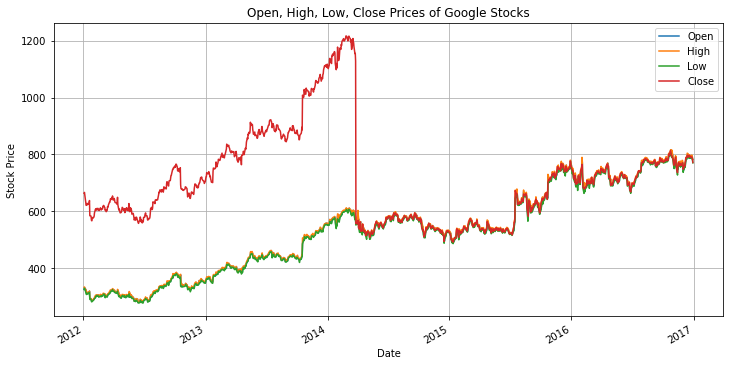

In [6]:
# visualize
fig = df.plot(
    x="Date", 
    y=["Open", "High", "Low", "Close"], 
    figsize=(12, 6),
    title='Open, High, Low, Close Prices of Google Stocks'
)
fig.set_ylabel("Stock Price")
fig.set_xlabel("Date")
plt.grid(True)
plt.show()

In [7]:
# select only features, not date
data = df.drop('Date', axis=1)

In [8]:
# scale data to 0-1 range
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [9]:
# function to create sequences
def create_sequences(data, target_col_index, seq_len=60):
    x, y = [], []
    for i in range(seq_len, len(data)):
        x.append(data[i-seq_len:i])            # shape: (60, num_features)
        y.append(data[i, target_col_index])    # only close price
    return np.array(x), np.array(y)


x, y = create_sequences(scaled_data, target_col_index=3)

In [10]:
# train-test split
split = int(len(x) * 0.8)
x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

### Build & Train LSTM

In [11]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)  # predicts a single value i.e. close price
])

# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            17920     
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 51,009
Trainable params: 51,009
Non-trainable params: 0
_________________________________________________________________


In [12]:
# train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
30/30 [==============================] - 7s 89ms/step - loss: 0.0376 - val_loss: 0.0055
Epoch 2/50
30/30 [==============================] - 2s 56ms/step - loss: 0.0080 - val_loss: 0.0039
Epoch 3/50
30/30 [==============================] - 2s 57ms/step - loss: 0.0068 - val_loss: 0.0011
Epoch 4/50
30/30 [==============================] - 2s 57ms/step - loss: 0.0060 - val_loss: 0.0025
Epoch 5/50
30/30 [==============================] - 2s 54ms/step - loss: 0.0048 - val_loss: 0.0012
Epoch 6/50
30/30 [==============================] - 2s 53ms/step - loss: 0.0054 - val_loss: 0.0017
Epoch 7/50
30/30 [==============================] - 2s 60ms/step - loss: 0.0045 - val_loss: 0.0019
Epoch 8/50
30/30 [==============================] - 2s 60ms/step - loss: 0.0042 - val_loss: 5.8342e-04
Epoch 9/50
30/30 [==============================] - 2s 58ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 10/50
30/30 [==============================] - 2s 61ms/step - loss: 0.0043 - val_loss: 0.0025
Epoch

### Evaluation & Prediction

In [13]:
y_pred = model.predict(x_test)

8/8 [==============================] - 2s 15ms/step


In [14]:
# dummy scaler to inverse transform Close column only
close_scaler = MinMaxScaler()

# copy over the min_ and scale_ values for the Close column from the original scaler (index 3)
close_scaler.min_, close_scaler.scale_ = scaler.min_[3:4], scaler.scale_[3:4]

In [15]:
# inverse transform
predicted_values = close_scaler.inverse_transform(y_pred)
actual_values = close_scaler.inverse_transform(y_test.reshape(-1, 1))

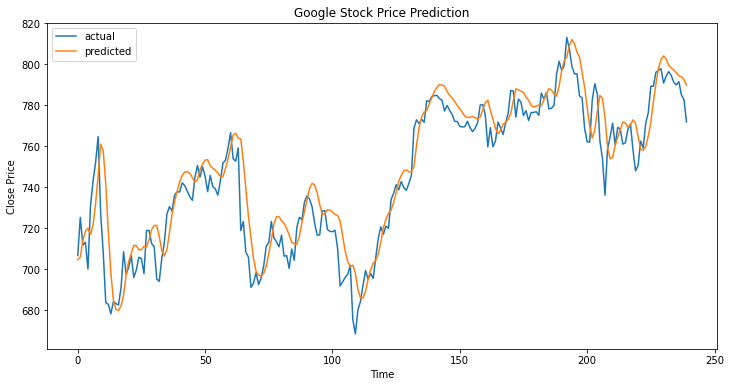

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(actual_values, label='actual')
plt.plot(predicted_values, label='predicted')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [36]:
# metrics
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
mae = mean_absolute_error(actual_values, predicted_values)
r2 = r2_score(actual_values, predicted_values)

print('RMSE: ', rmse)
print('MAE: ', mae)
print('R2 Score: ', r2)

RMSE:  12.977055399772405
MAE:  9.55937334187826
R2 Score:  0.8589645862979302
